# inference.ipynb
Scratch notebook to run cosmological parameter inference from the output of the Go Big simulations.

In [1]:
import os
import os.path as osp
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import sbi
import pandas as pd
from tqdm import tqdm


In [26]:
lh_lookup = pd.read_csv('latin_hypercube_params_bonus.txt', 
                        delimiter=' ', header=None, names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
def theta_value(lhid):
    return lh_lookup.iloc[lhid+1].values

In [27]:
datapath = '/home/mattho/git/cmass-ili/data/borg-quijote/latin_hypercube_HR-L3000-N384'
simdirs = os.listdir(datapath)

Pktrain = []
thtrain = []
for s in tqdm(range(4,101)):
    pkpath = pjoin(datapath, str(s), 'Pk')
    if osp.isdir(pkpath):
        pklist = os.listdir(pkpath)
        out = [np.load(pjoin(pkpath, x)) for x in pklist]
        out = np.stack([np.array(list(x.values())) for x in out])
        
        k = out[0,0]
        Pk = out[:,1:,:].reshape(len(out), -1)
        Pktrain.append(Pk)
        thtrain.append([theta_value(s)]*len(Pk))

100%|██████████| 97/97 [00:02<00:00, 47.42it/s]


In [28]:
Pktrain = np.concatenate(Pktrain, axis=0)
thtrain = np.concatenate(thtrain, axis=0)

Pktrain[Pktrain<0] = 1
Pktrain = np.log10(Pktrain)

In [29]:
lhid = 1999
x0 = np.load('/home/mattho/git/cmass-ili/data/borg-quijote/latin_hypercube_HR-L3000-N384/1999/Pk/Pk0.npz')
x0 = np.array(list(x0.values()))[1:].reshape(1,-1)
thtest = np.array(theta_value(lhid))

x0[x0<0]=1
x0 = np.log10(x0)

In [58]:
import torch
import numpy as np

from sbi import utils as utils
from sbi.inference import SNPE
from sbi.inference import DirectPosterior

tmin, tmax = thtrain.min(axis=0), thtrain.max(axis=0)
prior = utils.BoxUniform(low=tmin, high=tmax)

inference = SNPE()
posterior_estimator = inference.append_simulations(thtrain, Pktrain).train()
posterior = DirectPosterior(posterior_estimator, prior=prior).set_default_x(x0)

 Neural network successfully converged after 33 epochs.

In [60]:
t = posterior.sample(sample_shape=(1000,))

Drawing 1000 posterior samples: 1266it [00:05, 243.66it/s]                         


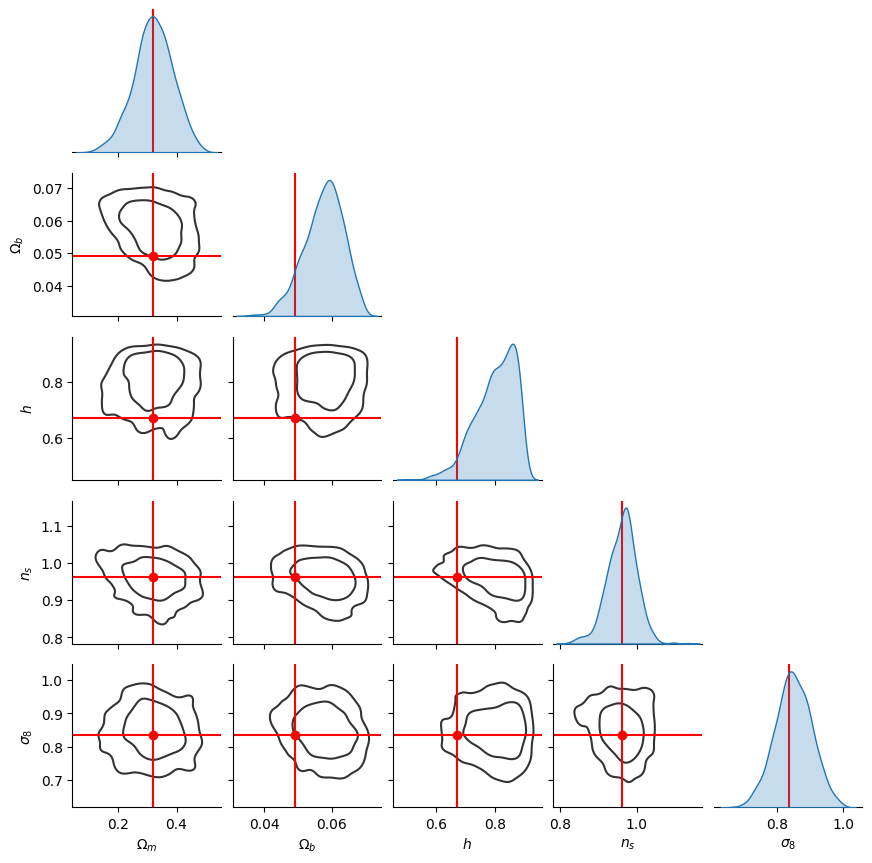

In [62]:
import seaborn as sns
labels = ['$\Omega_m$', '$\Omega_b$', '$h$', '$n_s$', '$\sigma_8$']
theta_obs = thtest

g = sns.pairplot(
    pd.DataFrame(t, columns=labels),
    kind=None,
    diag_kind="kde",
    corner=True,
    height=1.75
)
g.map_lower(sns.kdeplot, levels=[0.05,0.32], color=".2")

ndim = len(theta_obs)
for i in range(ndim):
    for j in range(i + 1):
#         g.axes[i,j].set_xlim(tmin[j], tmax[j])
        if i == j:
            g.axes[i, i].axvline(theta_obs[i], color="r")
        else:
            g.axes[i, j].axhline(theta_obs[i], color="r")
            g.axes[i, j].axvline(theta_obs[j], color="r")
            g.axes[i, j].plot(theta_obs[j], theta_obs[i], "ro")
g.savefig('images/fiducial_constraint.jpg', dpi=180)